[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/codescv/blog_v2/blob/main/posts/sd/stable-diffusion-2.ipynb)

This is the second one of the Stable Diffusion tutorial series. In this tutorial, we will learn how to fine-tune the stable diffusion model on new images (aka Dreambooth).

# Setup

First let's install all the dependencies we need to train the model. To avoid losing the model and the data, we will save them in the Google Drive. Make sure you have enough space left in your Google Drive before continuing.

In [ ]:
import pathlib
from google.colab import drive
drive.mount('/content/drive')

!pip install -Uqq git+https://github.com/huggingface/diffusers.git transformers ftfy gradio accelerate bitsandbytes fastai fastbook

if not pathlib.Path('/content/diffusers').exists():
  !git clone https://github.com/huggingface/diffusers

import huggingface_hub
if not pathlib.Path('/root/.huggingface/token').exists():
  huggingface_hub.notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


# Preparing Images


## Getting Images

For the purpose of this tutorial, let's download some images from DuckDuckGo. Alternatively you can prepare your own images and put them inside a Google Drive Folder (referred to as `images_src_dir` in the next sections).

In [ ]:
import pathlib
from fastbook import search_images_ddg, download_images, verify_images, get_image_files

def download_images_for_keyword(keyword: str, download_dir: str, max_images):
  dest = pathlib.Path(download_dir)
  dest.mkdir(exist_ok=True)
  results = search_images_ddg(keyword, max_images=max_images)
  download_images(dest, urls=results)
  downloaded_files = get_image_files(dest)
  failed = verify_images(downloaded_files)
  num_failed = len(failed)
  if num_failed > 0:
    print(f'Removing {num_failed} images')
    failed.map(pathlib.Path.unlink)

keyword = 'Saito Asuka' #@param {type: "string"}
download_dir = '/content/drive/MyDrive/sd/images_download' #@param {type: "string"}
max_images = 40 #@param {type: "slider", min:20, max:100, step:1}
force_redownload = False #@param {type:"boolean"}

if not pathlib.Path(download_dir).exists() or force_redownload:
  download_images_for_keyword(keyword=keyword, download_dir=download_dir, max_images=max_images)

## Cropping and Resizing

Although SD doesn't put restrictions on image sizes (other than the width and height should be divisible by 8), we preform center crop and resize on all images to make them the same square shape, since the training batches need to be same dimensions.

Cropping might result in bad images, but no worries, we will clean them up in the next section.

In [ ]:
import PIL
import pathlib
from fastai.vision.widgets import ImagesCleaner
from fastai.vision.all import PILImage
from fastbook import get_image_files

images_src_dir = '/content/drive/MyDrive/sd/images_download' #@param {type: "string"}
images_train_dir = '/content/drive/MyDrive/sd/images_training' #@param {type: "string"}
size = 768 #@param {type: "slider", min:256, max:768, step:128}
images_dir = pathlib.Path(images_train_dir)
images_dir.mkdir(exist_ok=True)

for idx, image_file in enumerate(get_image_files(images_src_dir)):
  im = PILImage.create(image_file)
  im = im.crop_pad(min(im.size)).resize_max(max_h=size)
  im.save(images_dir / image_file.name)

In [ ]:
!ls "{images_src_dir}" |wc -l
!ls "{images_train_dir}" |wc -l

34
34


## Cleaning Up Images

One of the most important things of any ML applications, if not THE most important - is the data quality. To get best quality, let's check our training images and remove the "bad" ones (especially the ones that doesn't contain complete faces after cropping - we don't want the final model to learn to generate half faces!)

FastAI provides an [ImagesCleaner](https://docs.fast.ai/vision.widgets.html#imagescleaner) class which is a very cool tool for removing images from the Jupyter notebook. Just select "Delete" for the images you want to delete, and then run the following cells to delete them.


In [ ]:
fns = get_image_files(images_train_dir)
w = ImagesCleaner(max_n=100)
w.set_fns(fns)
w

Box(children=(VBox(children=(Output(layout=Layout(height='128px')), Dropdown(layout=Layout(width='max-content'…

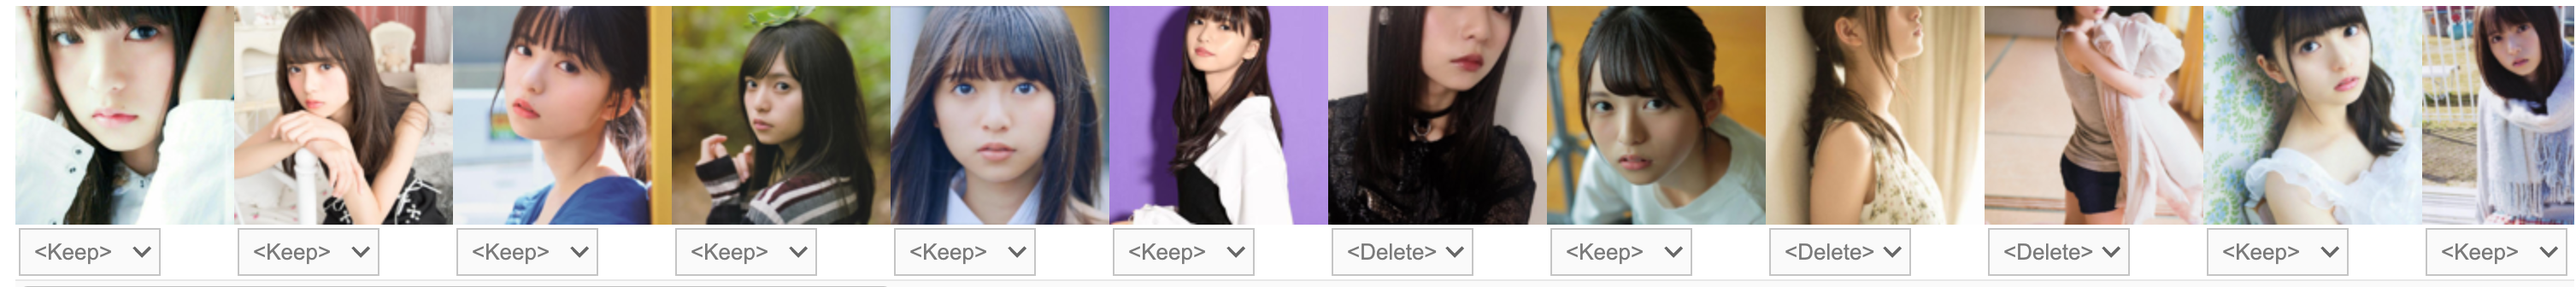

In [3]:
#| echo: false
import PIL; PIL.Image.open('raw.png')

In [ ]:
w.fns[w.delete()].map(pathlib.Path.unlink)

(#5) [None,None,None,None,None]

In [ ]:
fns = get_image_files(images_train_dir)
w_clean = ImagesCleaner(max_n=100)
w_clean.set_fns(fns)
w_clean

Box(children=(VBox(children=(Output(layout=Layout(height='128px')), Dropdown(layout=Layout(width='max-content'…

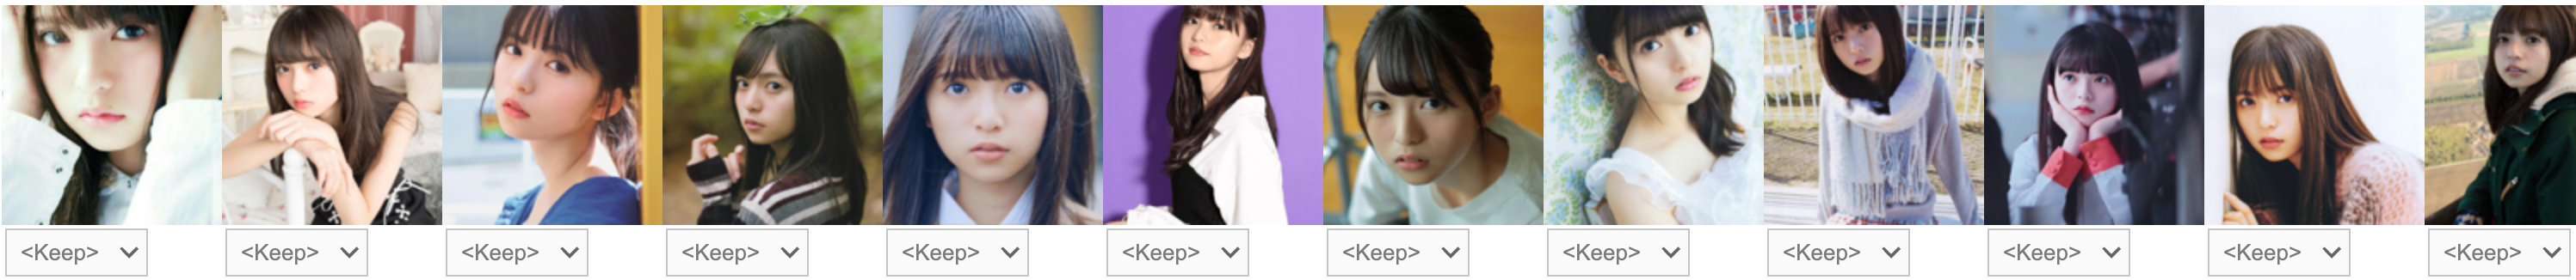

In [4]:
#| echo: false
import PIL; PIL.Image.open('cleaned.png')

# Training
## Using the diffusers example script

First let's train with the diffusers example [script](https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/train_dreambooth.py).

There are a few params worth noting:

- `MODEL_NAME` This is the id of your base model, e.g. SD1.5 or SD2.0. By default for training the SD2.0 with 768 resolution ("stabilityai/stable-diffusion-2") you will need more than 16GB memory (about 22GB without xformers from my experiments).
- `STEPS` The number of steps to train. Recommended value is ${num\_examples} \times 200 $.
- `SAVE_STEPS` The model will be exported every X steps, to avoid losing all progress when your GPU is recycled, or enable comparing different checkpoints to see which is best.
- `OUTPUT_DIR` This is where the trained model is exported.
- `INSTANCE_DIR` This points to the training images.
- `INSTANCE_PROMPT` This is the prompt for the training instances. In the diffusers example we are using a fixed prompt "a photo of xyz" for every instance image. This may not be optimal, and we'll see how we can improve it later on.

Make sure you selected GPU runtime (preferrably the best GPU you can choose) before continuing.

In [ ]:
MODEL_NAME="stabilityai/stable-diffusion-2" #@param ["runwayml/stable-diffusion-v1-5", "CompVis/stable-diffusion-v1-4", "stabilityai/stable-diffusion-2", "stabilityai/stable-diffusion-2-base"]
STEPS=10000 #@param {type: "integer"}
SAVE_STEPS=3000 #@param {type: "integer"}
OUTPUT_DIR="/content/drive/MyDrive/sd/models/asuka" #@param {type: "string"}
INSTANCE_DIR="/content/drive/MyDrive/sd/images_training" #@param {type: "string"}
INSTANCE_PROMPT="a photo of saitoasuka" #@param {type: "string"}
LEARNING_RATE=4e-6 #@param {type: "number"}

if MODEL_NAME == "stabilityai/stable-diffusion-2":
  resolution = 768
else:
  resolution = 512

!accelerate launch /content/diffusers/examples/dreambooth/train_dreambooth.py \
  --train_text_encoder \
  --pretrained_model_name_or_path="{MODEL_NAME}"  \
  --instance_data_dir="{INSTANCE_DIR}" \
  --output_dir="{OUTPUT_DIR}" \
  --instance_prompt="{INSTANCE_PROMPT}" \
  --resolution={resolution} \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --learning_rate={LEARNING_RATE} \
  --lr_scheduler="polynomial" \
  --use_8bit_adam \
  --gradient_checkpointing \
  --lr_warmup_steps=0 \
  --save_steps={SAVE_STEPS} \
  --max_train_steps={STEPS}

# Web UI Demo

Now we have the model, we can use the Pipeline API to make predictions. To facilitate experiments, I have created a Web UI, inspired by [AUTOMATIC1111](
https://github.com/AUTOMATIC1111/stable-diffusion-webui/blob/master/modules/ui.py). The difference is that here we use the diffusers Pipeline, unlike the AUTOMATIC1111 web UI which uses the original stable diffusion codebase.

- The `model_id` is the path to your trained model i.e. (`OUTPUT_DIR` in the last section). You can also use the standard model ids and compare.
- `output_dir` is a directory where predicted images will be saved. If empty images will saved in the `model_path / outputs` directory.


In [ ]:
import shutil
import gradio as gr
import PIL
import numpy as np
import torch
import requests
import random
import pathlib
import os
import json
import uuid
from io import BytesIO
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, StableDiffusionInpaintPipeline, DiffusionPipeline
from diffusers import EulerAncestralDiscreteScheduler, DDIMScheduler, DPMSolverMultistepScheduler

# prompt engineering
artists = ['Aaron Douglas','Agnes Lawrence Pelton','Akihiko Yoshida','Albert Bierstadt','Albert Bierstadt','Alberto Giacometti',
           'Alberto Vargas','Albrecht Dürer','Aleksi Briclot','Alex Grey','Alex Horley-Orlandelli','Alex Katz','Alex Ross',
           'Alex Toth','Alexander Jansson','Alfons Maria Mucha','Alfred Kubin','Alphonse Mucha','Anato Finnstark','Anders Zorn',
           'André Masson','Andreas Rocha','Andrew Wyeth','Anish Kapoor','Anna Dittmann','Anna Mary Robertson Moses','Anni Albers',
           'Ansel Adams','Anthony van Dyck','Anton Otto Fischer','Antonio Mancini','April Gornik','Arnold Böcklin','Art Spiegelman',
           'Artemisia Gentileschi','Artgerm','Arthur Garfield Dove','Arthur Rackham','Asher Brown Durand','Aubrey Beardsley',
           'Austin Briggs','Ayami Kojima','Bastien Lecouffe-Deharme','Bayard Wu','Beatrix Potter','Beeple','Beksinski',
           'Bill Sienkiewicz','Bill Ward','Bill Watterson','Bob Eggleton','Boris Vallejo','Brian Bolland','Brian Froud',
           'Bruce Pennington','Bunny Yeager','Camille Corot','Camille Pissarro','Canaletto','Caravaggio','Caspar David Friedrich',
           'Cedric Peyravernay','Charles Addams','Charles Dana Gibson','Chesley Bonestell','Chris Foss','Chris Moore',
           'Chris Rallis','Chriss Foss','Cindy Sherman','Clara Peeters','Claude Monet','Clyde Caldwell','Coles Phillips',
           'Cornelis Bisschop','Coby Whitmore','Craig Mullins','Cynthia Sheppard','Dale Chihuly','Damien Hirst','Dan Mumford',
           'Daniel Merriam','Darek Zabrocki','Dave Dorman','Dave Gibbons','Dave McKean','David Firth','Dean Cornwell','Dean Ellis',
           'Diane Dillon','Disney','Don Maitz','Donato Giancola','Dorothea Tanning','Dreamworks','Dr. Seuss','Earl Norem',
           'Earle Bergey','Earnst Haeckel','Ed Emshwiller','Edgar Degas','Edmund Dulac','Edmund Leighton','Édouard Manet',
           'Edvard Munch','Edward Burne-Jones','Edward Gorey','Edward Hopper','Edward Lear','Edwin Austin Abbey','Edwin Deakin',
           'Egon Schiele','El Greco','Elizabeth Shippen Green','Emmanuel Shiu','Emory Douglas','Esao Andrews','Eugène Delacroix',
           'Evelyn De Morgan','E.H. Shepard','F. Scott Hess','Fairfield Porter','Federico Pelat','Filippino Lippi','Fitz Henry Lane',
           'Francis Bacon','Francisco Goya','Frank Frazetta','Frank Xavier Leyendecker','Franklin Booth','Franz Sedlacek',
           'Frederick Edwin Church','Frederick McCubbin','Gaston Bussière','Gediminas Pranckevicius','Geof Darrow',
           'George B. Bridgman','George Cruikshank','George Inness','George Luks',"Georgia O'Keeffe",'Gerald Brom','Giacomo Balla',
           'Gil Elvgren','Gillis Rombouts','Giorgio de Chirico','Giorgione','Giovanni Battista Piranesi','Greg Hildebrandt',
           'Greg Rutkowski','Greg Staples','Gregory Manchess','Guido Borelli da Caluso','Gustaf Tenggren','Gustav Klimt',
           'Gustave Doré','Gustave Moreau','Gwen John','Hannah Höch','Hans Baldung','Hans Bellmer','Harrison Fisher','Harvey Dunn',
           'Harvey Kurtzman','Henri de Toulouse-Lautrec','Henri Matisse','Henri Rousseau','Henry Ossawa Tanner','Henry Raleigh',
           'Hethe Srodawa','Hieronymus Bosch','Hiromu Arakawa','Hokusai','Howard Chandler Christy','Howard Pyle','Hubert Robert',
           'Hugh Ferriss','Hyun Lee','H.R. Giger','Igor Kieryluk','Igor Morski','Igor Wolkski','Ilya Kuvshinov','Ilya Repin',
           'Inyi Han','Isaac Levitan','Ivan Aivazovsky','Ivan Albright','Ivan Bilibin','Ivan Shishkin','Jacek Yerka','Jack Kirby',
           'Jackson Pollock','Jakub Rozalski','James C. Christensen','James Gillray','James Gurney','James Jean','James Paick',
           'Jamie Hewlett','Jan van Eyck','Janet Fish','Jasper Johns','J.C. Leyendecker','Jean Delville','Jean Giraud',
           'Jean Metzinger','Jean-Honoré Fragonard','Jean-Michel Basquiat','Jeff Easley','Jeff Koons','Jeffrey Smith',
           'Jerome Lacoste','Jerry Pinkney','Jesper Ejsing','Jessie Willcox Smith','Jim Burns','Jim Steranko','Joaquín Sorolla',
           'Joe Jusko','Johannes Vermeer','Johfra Bosschart','John Atkinson Grimshaw','John Bauer','John Berkey','John Constable',
           'John Frederick Kensett','John French Sloan','John Harris','John Howe','John James Audubon','John Martin',
           'John Philip Falter','John Romita Jr','Jon Foster','Jon Whitcomb','Joseph Cornell','Juan Gris','Junji Ito',
           'J.M.W. Turner','Kadir Nelson','Kandinsky','Karol Bak','Kate Greenaway','Kawanabe Kyōsai','Kay Nielsen',
           'Keith Haring','Kelly Freas','Kelly Mckernan','Kim Jung Gi','Kinuko Craft','Konstantin Vasilyev',
           'Konstantinas Ciurlionis','Krenz Cushart','Lale Westvind','Larry Elmore','Laura Muntz Lyall','Laurel Burch',
           'Laurie Lipton','Lawren Harris','Lee Madgwick','Leo and Diane Dillon','Leonora Carrington','Liam Wong','Lise Deharme',
           'Lois van Baarle','Louis Glackens','Louis Janmot','Louise Bourgeois','Lucian Freud','Luis Royo','Lynda Benglis',
           'Lyubov Popova','Maciej Kuciara','Makoto Shinkai','Malevich','Marc Simonetti','Margaret Macdonald Mackintosh',
           'Maria Sibylla Merian','Marianne North','Mario Sanchez Nevado','Mark Ryden','Martin Johnson Heade','Mary Cassatt',
           'Mati Klarwein','Maxfield Parrish','Mead Schaeffer','Michael Hussar','Michael Parkes','Michael Whelan',
           'Mikalojus Konstantinas Čiurlionis','Mike Mignola','Milton Caniff','Milton Glaser','Moebius','Mondrian','M.C. Escher',
           'Noah Bradley','Noriyoshi Ohrai','Norman Rockwell','N.C. Wyeth','Odd Nerdrum','Odilon Redon','Ohara Koson',
           'Paul Cézanne','Paul Delvaux','Paul Gauguin','Paul Klee','Paul Lehr','Peter Elson','Peter Gric','Peter Helck',
           'Peter Max','Peter Mohrbacher','Peter Paul Rubens','Pierre Bonnard','Pierre-Auguste Renoir','Pieter Bruegel the Elder',
           'Pieter Claesz','Pixar','P.A. Works','Rafal Olbinski','Ralph Horsley','Ralph McQuarrie','Randolph Caldecott',
           'Raphael Lacoste','Ray Caesar','Raymond Swanland','Rebecca Guay','Rembrandt','Rembrandt van Rijn','Rene Magritte',
           'RHADS','Richard Dadd','Richter','Rob Gonsalves','Robert Delaunay','Robert McCall','Robert McGinnis',
           'Robert Rauschenberg','Roberto da Matta','Rockwell Kent','Rodney Matthews','Roger Ballen','Roger Dean','Ron Walotsky',
           'Rossdraws','Ross Tran','Roz Chast','Salvador Dalí','Sam Spratt','Sandro Botticelli','Saul Steinberg','Saul Tepper',
           'Seb McKinnon','Simon Bisley','Simon Stalenhag','Sir John Tenniel','Slawomir Maniak','Sonia Delaunay','sparth',
           'Stephan Martiniere','Stevan Dohanos','Steve Dillon','Steven DaLuz','Studio Ghibli','Syd Mead','Sylvain Sarrailh',
           'Takashi Murakami','Takato Yamamoto','Takeshi Obata','Tamara Lempicka','Taro Okamoto','Ted DeGrazia','Ted Nasmith',
           'Terry Oakes','Terry Redlin','Thomas Cole','Thomas Kinkade','Thomas Nast','Thornton Oakley','Brothers Hildebrandt',
           'Tim White','Titian','Tom Lovell','Tom Thomson','Tomek Setowski','Tomer Hanuka','Tomi Ungerer','Tomokazu Matsuyama',
           'Tony Sart','Tsutomu Nihei','Tyler Edlin','Utagawa Kuniyoshi','Victo Ngai','Vincent Di Fate','Vladimir Kush',
           'Wally Wood','Walter Beach Humphrey','Walter Crane','Warwick Goble','Wassily Kandinsky','Wayne Barlowe','Wendy Froud',
           'Wifredo Lam','Will Eisner','William Hogarth','William Michael Harnett','William Steig','William Stout',
           'William-Adolphe Bouguereau','Winslow Homer','Winsor McCay','WLOP','Yayoi Kusama','Yoshitaka Amano','Yue Minjun',
           'Yves Tanguy','Zdzisław Beksiński']

juice = ['dynamic composition','cinematic lighting','intricate','studio quality','highly detailed',
          'digital painting', 'artstation', 'matte', 'sharp focus','hyper detailed', 'super sharp',
          'crisp', 'smooth', 'smooth gradients', 'depth of field','insanely detailed and intricate',
          'hypermaximalist', 'elegant', 'ornate', 'hyper realistic', 'super detailed', 'cinematic light',
          'ray tracing', 'volumetric lighting', 'octane render','cinematic lighting', 'highly detailed',
          'sharp focus', 'professional photoshoot', '8k', 'DOF','dramatically lit', '1ms shutter speed',
          'back lighting', 'F 2.8 lens']

style = ['2d game art','3D VR painting','8k resolution','1950s pulp sci-fi cover','anime','artistic photograph','Baroque painting','Byzantine mosaic','Chiaroscuro painting','depth of field','digital painting','dutch golden age','filmed in IMAX','fine art','flat shading','Flemish Baroque','Fresco painting','Gouache Painting','graffiti','Grisaille painting','highly detailed','hyperrealism','Impasto painting','low-poly','Luminism painting','Marvel Comics','matte painting','mixed media','oil painting','Panorama','parallax','pastel painting','pencil sketch','Perspective painting','Playstation 5 screenshot','pop art','raytracing','rendered in cinema4d','rendered in maya','rendered in zbrush','schematic','sculpture','Sfumato painting','shot on 70mm','Sotto In Su','storybook illustration','surrealist art','surveillance footage','Tempera Painting','tilt shift','Trompe L’oeil','Ukiyo-e','unreal engine render','vector image','Veduta painting','visionary hypermaximalism','volumetric lighting','vray tracing']
sites = ['500px','ArtStation','Behance','cgsociety','ConceptArtWorld','DeviantArt','Flickr','Getty Images','Pixiv','unsplash','zbrushcentral']
genre = ['anime','art deco','antique lithograph','concept','cyberpunk','dark fantasy','enlightenment','fantasy','fauvism','film noir','gothic','holography','linocut','massurrealism','medieval','monochrome','oil painting','pencil sketch','photoreal','post-impressionist','postmodern','psychedelic','renaissance','sci-fi','steampunk','clean vector','victorian','vintage','woodblock']

prompt_ideas_map = {'artists': artists,'juice': juice, 'style': style, 'sites': sites, 'genre': genre}

def get_random_style():
  styles = []
  for k, v in prompt_ideas_map.items():
    if k == 'artists':
      # only 1 artist
      if random.random() > 0.1:
        artist = random.choice(v)
        styles.append(f'by {artist}')
    else:
      count = random.randint(0, 3)
      if count > 0:
        styles.extend(random.sample(v, k=count))
  return ', '.join(styles)

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

model_id = '/content/drive/MyDrive/sd/models/asuka/checkpoint-6000' #@param {type: "string"}
output_dir = '' #@param {type: "string"}

if not output_dir:
  model_path = pathlib.Path(model_id)
  if model_path.exists():
    output_dir = model_path / 'outputs'
  else:
    output_dir = '/content/outputs'

pathlib.Path(output_dir).mkdir(exist_ok=True)
print(f'Images will be saved into {output_dir}')

_PIPE = StableDiffusionPipeline.from_pretrained(
      model_id,
      revision="fp16",
      torch_dtype=torch.float16,
).to("cuda")
_PIPE.safety_checker = None

_PIPE_I2I = StableDiffusionImg2ImgPipeline(
  vae=_PIPE.vae,
  text_encoder=_PIPE.text_encoder,
  tokenizer=_PIPE.tokenizer,
  unet=_PIPE.unet,
  scheduler=_PIPE.scheduler,
  safety_checker=None,
  feature_extractor=None,
  requires_safety_checker=False
)

PIPES = {
    'text2image': _PIPE,
    'image2image': _PIPE_I2I
}

SCHEDULERS = {
    'euler': EulerAncestralDiscreteScheduler(
        num_train_timesteps=1000,
        beta_end=0.012,
        beta_start=0.00085,
        beta_schedule="linear",

    ),
    'ddim_v': DDIMScheduler(
        beta_start=0.00085,
        beta_end=0.012,
        beta_schedule="scaled_linear",
        clip_sample=False,
        prediction_type='v_prediction',
        set_alpha_to_one=False),
    'default': _PIPE.scheduler,
}

def save_image(image, info):
  out_dir = pathlib.Path(output_dir)
  rnd_str = uuid.uuid4().hex[:8]
  image_filename = out_dir / f'{rnd_str}.jpg'
  image.save(image_filename)
  info_filename = out_dir / f'{rnd_str}.json'
  with open(info_filename, 'w') as out:
    out.write(json.dumps(info))

def text2image(prompt,
               image,
               negative_prompt=None,
               size=512,
               scheduler='ddim',
               steps=35,
               seed=None,
               strength=0.5,
               num_images=3,
               style=None):
  if style:
    prompt = f'{prompt}, {style}'

  if seed is None:
    seed = random.randint(0,1000000)

  generator = torch.Generator(device="cuda").manual_seed(seed)
  results = []
  if size <= 512:
    num_images_per_prompt = 3
  else:
    num_images_per_prompt = 1

  if image is not None:
    pipe = PIPES['image2image']
  else:
    pipe = PIPES['text2image']
  pipe.scheduler = SCHEDULERS[scheduler]

  for _ in range(num_images // num_images_per_prompt):
    if image is not None:
      image = image.resize((size, size))
      images = pipe(prompt=prompt,
                    image=image,
                    num_inference_steps=steps,
                    negative_prompt=negative_prompt,
                    generator=generator,
                    strength=strength,
                    num_images_per_prompt=num_images_per_prompt).images
    else:
      images = pipe(prompt=prompt,
                    height=size,
                    width=size,
                    num_inference_steps=steps,
                    negative_prompt=negative_prompt,
                    generator=generator,
                    num_images_per_prompt=num_images_per_prompt).images
    results.extend(images)

  for image in results:
    save_image(image, info={
        'prompt': prompt,
        'negative_prompt': negative_prompt,
        'scheduler': scheduler,
        'seed': seed,
    })
  return results


examples = [
    ['A portrait of saitoasuka wearing a baseball hat'],
]

neg_prompt_examples = [
    ['disfigured, kitsch, ugly, oversaturated, greain, low-res, Deformed, blurry, bad anatomy, disfigured, poorly drawn face, mutation, mutated, extra limb, ugly, poorly drawn hands, missing limb, blurry, floating limbs, disconnected limbs, malformed hands, blur, out of focus, long neck, long body, ugly, disgusting, poorly drawn, childish, mutilated, , mangled, old, surreal'],
    ['cartoon, 3d, ((disfigured)), ((bad art)), ((deformed)), ((poorly drawn)), ((extra limbs)), ((close up)), ((b&w)), weird colors, blurry'],
]

def send_image_to_input(image):
  if image:
    return PIL.Image.open(image['name'])
  return None

with gr.Blocks() as demo:
  gr.Markdown('SD Demo')

  gr.HTML(r"""
  <style>
    #random_seed_button, #get_style_button {
      height: 100%;
    }
  </style>
  """)

  with gr.Row():
    with gr.Column():
      gr.Markdown('Inputs')

      image_input = gr.Image(label='Image', type='pil')

      prompt = gr.Textbox(label='Prompt', value=examples[0][0])

      with gr.Box():
        with gr.Row():
          with gr.Column(scale=4):
            style = gr.Textbox(label='style')
          with gr.Column(scale=1, min_width=50, variant='compact'):
            generate_style_button = gr.Button(value='Get Random Style', elem_id='get_style_button')

      negative_prompt = gr.Textbox(label='Negative Prompt', value=neg_prompt_examples[0][0])
      scheduler = gr.Radio(label='scheduler', value='default', choices=['euler', 'ddim_v', 'default'])
      steps = gr.Slider(label='steps', value=50, minimum=10, maximum=200)

      with gr.Box():
        with gr.Row():
          with gr.Column(scale=8):
            seed = gr.Number(label='seed', value=42, precision=0)
          with gr.Column(scale=1, min_width=5, variant='compact'):
            random_seed_button = gr.Button('\U0001f3b2\ufe0f', elem_id='random_seed_button')

      num_images = gr.Slider(label='Number of images to generate', value=3, minimum=3, maximum=12, step=3)
      size = gr.Slider(label='Size', value=512, minimum=256, maximum=1024, step=128)
      strength = gr.Slider(label="Transformation strength (for image2image)", minimum=0, maximum=1, step=0.01, value=0.5)
      submit_button = gr.Button(value="Generate", variant='primary')

    with gr.Column():
      gr.Markdown('Output')
      image_output = gr.Gallery(label="Generated Images").style(grid=[3], height=1024)
      send_to_input_button = gr.Button(value='Send to Input')

  with gr.Row():
    gr.Examples(examples, inputs=[prompt], label='Prompts')
    gr.Examples(neg_prompt_examples, inputs=[negative_prompt], label='Negative Prompts')

  submit_button.click(text2image,
                      inputs=[prompt, image_input, negative_prompt, size, scheduler, steps, seed, strength, num_images, style],
                      outputs=image_output)
  random_seed_button.click(fn=lambda: random.randint(0,1000000), show_progress=False, inputs=[], outputs=[seed])

  generate_style_button.click(
      get_random_style,
      outputs=style
  )

  send_to_input_button.click(
      send_image_to_input,
      _js='get_output_image',
      inputs=image_output,
      outputs=image_input)


try:
  original_template_response
except:
  original_template_response = gr.routes.templates.TemplateResponse

def template_response(*args, **kwargs):
  res = original_template_response(*args, **kwargs)
  javascript = r"""
    <script>
      function gradioApp(){
        return document.getElementsByTagName('gradio-app')[0].shadowRoot;
      }

      function selected_gallery_index(){
        var buttons = gradioApp().querySelectorAll('.transition-all.gallery-item')
        var button = gradioApp().querySelector('.transition-all.gallery-item.\\!ring-2')

        var result = -1
        buttons.forEach(function(v, i){ if(v==button) { result = i } })

        return result
      }

      function get_output_image(gallery) {
        console.log(gallery);
        var index = selected_gallery_index();
        console.log(index);
        if (gallery.length == 1)
          index = 0;

        if (index < 0)
          return null;
        else {
          return gallery[index];
        }
      }
    </script>
  """
  res.body = res.body.replace(
      b'</head>', f'{javascript}</head>'.encode("utf8"))
  res.init_headers()
  return res
gr.routes.templates.TemplateResponse = template_response

demo.launch(debug=True, share=True)

# Results

I tried an experiemnts using the same prompts with random styles

Experiment Params:

- Steps: 6000
- Prompt
```
A portrait of saitoasuka wearing a baseball hat
```
- Negative Prompts
```
disfigured, kitsch, ugly, oversaturated, greain, low-res, Deformed, blurry, bad anatomy, disfigured, poorly drawn face, mutation, mutated, extra limb, ugly, poorly drawn hands, missing limb, blurry, floating limbs, disconnected limbs, malformed hands, blur, out of focus, long neck, long body, ugly, disgusting, poorly drawn, childish, mutilated, , mangled, old, surreal
```
- Seed: 42

Here are the results:

In [ ]:
#| echo: false
from fastai.vision.widgets import ImagesCleaner
from fastbook import get_image_files

fns = get_image_files('/content/drive/MyDrive/sd/models/asuka/checkpoint-6000/outputs')
w = ImagesCleaner(max_n=100)
w.set_fns(fns)
w

Box(children=(VBox(children=(Output(layout=Layout(height='128px')), Dropdown(layout=Layout(width='max-content'…

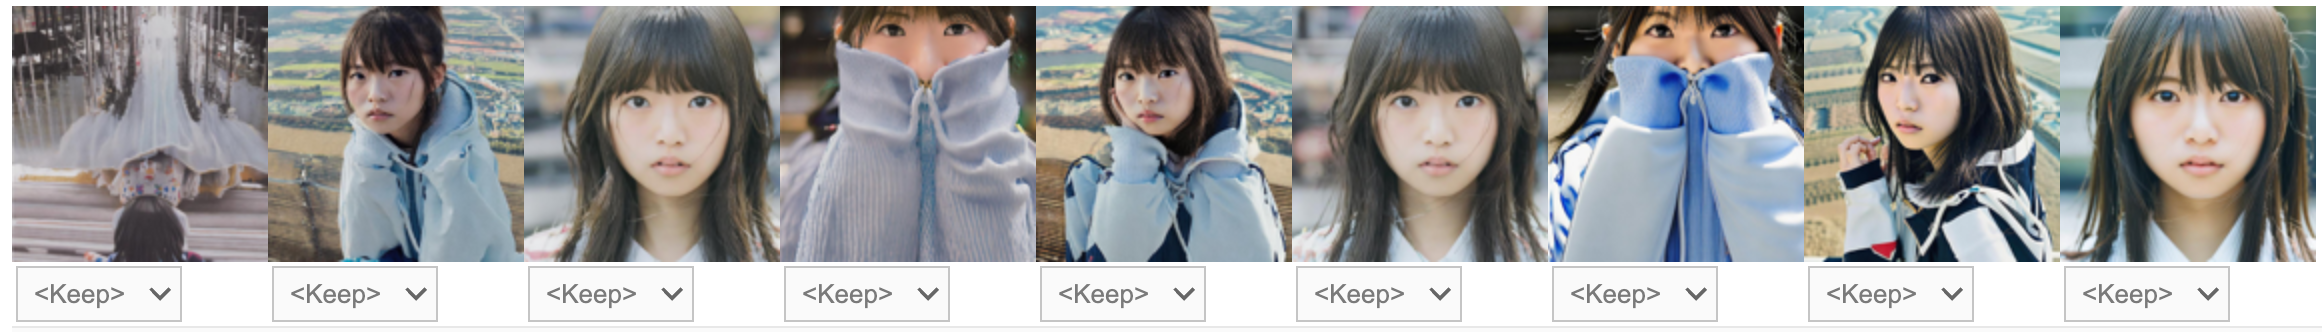

In [5]:
#| echo: false
import PIL; PIL.Image.open('results.png')

Image quality looks ok, but none of them is wearing hats! This may be due to the fact that we are always using the same "a photo of xyz" for the prompts, and the model forgets about what "hat" means.

# Improving the Results

## Using BLIP Captions

In the vanilla case, we used the same prompt for every image instance, which can be not ideal for the model - this is a training / testing mismatch. Because in training we have the same short prompt, but in validation we use very different prompts.

[BLIP](https://github.com/salesforce/BLIP) is a model for generating text from images. We can use this model to automatically generate some informative descriptions and append to the prompts. This could help our model to generalize better.

In [ ]:
INSTANCE_DIR="/content/drive/MyDrive/sd/images_training" #@param {type: "string"}

import os
import sys

if not os.path.exists('/content/BLIP'):
  !rm -rf /content/BLIP
  !git clone https://github.com/salesforce/BLIP.git
  !pip install -Uqq timm fairscale pycocoevalcap

if '/content/BLIP' not in sys.path:
  sys.path.append('/content/BLIP')

from models.blip import blip_decoder
from torchvision import transforms
import PIL
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

image_size = 384
transform = transforms.Compose([
  transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
  transforms.ToTensor(),
  transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_caption.pth'
model = blip_decoder(pretrained=model_url, med_config='/content/BLIP/configs/med_config.json', image_size=image_size, vit='large')
model.eval()
model = model.to(device)

def image2text(raw_image):
  image = transform(raw_image).unsqueeze(0).to(device)
  results = []
  with torch.no_grad():
    for _ in range(5):
      caption = model.generate(image, sample=True, top_p=0.9, max_length=20, min_length=5)
      results.extend(caption)
  return results

print('generating blip captions')
image_captions = {}
for image_filename in os.listdir(INSTANCE_DIR):
  image_filename_full = os.path.join(INSTANCE_DIR, image_filename)
  image = PIL.Image.open(image_filename_full).convert('RGB')
  text = image2text(image)
  image_captions[image_filename_full] = text

import pickle
with open('image_captions.pickle', 'wb') as f:
    pickle.dump(image_captions, f, protocol=pickle.HIGHEST_PROTOCOL)
print('finished generating blip captions')

## Training

We are using the diffusers training scripts as a base, and make changes to the `DreamboothDataset` class so that it can now accept an additional parameter `image_captions` containing prompt mappings. For accelerate to run in Colab, we made some small changes, but those should be quite straightforward.

In [ ]:
PRETRAINED_MODEL = "stabilityai/stable-diffusion-2" #@param ["runwayml/stable-diffusion-v1-5", "CompVis/stable-diffusion-v1-4", "stabilityai/stable-diffusion-2", "stabilityai/stable-diffusion-2-base"] {allow-input: true, type: "string"}
STEPS=10000 #@param {type: "integer"}
SAVE_STEPS=3000 #@param {type: "integer"}
OUTPUT_DIR="/content/drive/MyDrive/sd/models/asuka_blip_v2" #@param {type: "string"}
INSTANCE_DIR="/content/drive/MyDrive/sd/images_training" #@param {type: "string"}
INSTANCE_PROMPT="a photo of saitoasuka" #@param {type: "string"}
USE_BLIP_CAPTIONS = True #@param {type:"boolean"}
LEARNING_RATE=3e-6 #@param {type: "number"}

from argparse import Namespace
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL
import random
import pickle

args = Namespace(
    pretrained_model_name_or_path=PRETRAINED_MODEL, # Path to pretrained model or model identifier from huggingface.co/models.
    revision=None,  # Revision of pretrained model identifier from huggingface.co/models.
    tokenizer_name=None, # Pretrained tokenizer name or path if not the same as model_name
    instance_data_dir=INSTANCE_DIR, # A folder containing the training data of instance images.
    class_data_dir=None, # A folder containing the training data of class images.
    instance_prompt=INSTANCE_PROMPT, # The prompt with identifier specifying the instance
    class_prompt=None, # The prompt to specify images in the same class as provided instance images.
    with_prior_preservation=False, # Flag to add prior preservation loss.
    prior_loss_weight=1.0, # The weight of prior preservation loss.
    num_class_images=100, # Minimal class images for prior preservation loss. If not have enough images, additional images will be sampled with class_prompt.
    output_dir=OUTPUT_DIR, # The output directory where the model predictions and checkpoints will be written.
    seed=None, # A seed for reproducible training.
    resolution=768 if PRETRAINED_MODEL == "stabilityai/stable-diffusion-2" else 512, # The resolution for input images, all the images in the train/validation dataset will be resized to this resolution
    center_crop=True, # Whether to center crop images before resizing to resolution
    train_text_encoder=True, # Whether to train the text encoder
    train_batch_size=1, # Batch size (per device) for the training dataloader.
    sample_batch_size=4, # Batch size (per device) for sampling images.
    num_train_epochs=1,
    max_train_steps=STEPS, # Total number of training steps to perform.  If provided, overrides num_train_epochs.
    save_steps=SAVE_STEPS, # Save checkpoint every X updates steps.
    gradient_accumulation_steps=1, # Number of updates steps to accumulate before performing a backward/update pass.
    gradient_checkpointing=True, # Whether or not to use gradient checkpointing to save memory at the expense of slower backward pass.
    learning_rate=LEARNING_RATE, # Initial learning rate (after the potential warmup period) to use.
    scale_lr=False, # Scale the learning rate by the number of GPUs, gradient accumulation steps, and batch size.
    lr_scheduler="polynomial", # The scheduler type to use. Choose between ["linear", "cosine", "cosine_with_restarts", "polynomial", "constant", "constant_with_warmup"]
    lr_warmup_steps=0, # Number of steps for the warmup in the lr scheduler.
    use_8bit_adam=True, # Whether or not to use 8-bit Adam from bitsandbytes
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_weight_decay=1e-2,
    adam_epsilon=1e-8,
    max_grad_norm=1.0,
    push_to_hub=False,
    hub_token=None,
    hub_model_id=None,
    logging_dir='logs',
    mixed_precision=None, # ["no", "fp16", "bf16"]
    local_rank=-1 # For distributed training: local_rank
)


if not os.path.exists('train_dreambooth.py'):
  !cd /content/
  !wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth.py -O train_dreambooth.py

assert os.path.exists('train_dreambooth.py'), 'Unable to download train_dreambooth.py'
import train_dreambooth
train_dreambooth.args = args
from train_dreambooth import *


if USE_BLIP_CAPTIONS:
  with open('image_captions.pickle', 'rb') as f:
    image_captions = pickle.load(f)
else:
  image_captions = {}
print('Using image captions:', image_captions)


class DreamBoothDataset(Dataset):
    """
    A dataset to prepare the instance and class images with the prompts for fine-tuning the model.
    It pre-processes the images and the tokenizes prompts.
    """

    def __init__(
        self,
        instance_data_root,
        instance_prompt,
        tokenizer,
        image_captions=None,
        class_data_root=None,
        class_prompt=None,
        size=512,
        center_crop=False,
    ):
        self.size = size
        self.center_crop = center_crop
        self.tokenizer = tokenizer

        self.instance_data_root = Path(instance_data_root)
        if not self.instance_data_root.exists():
            raise ValueError("Instance images root doesn't exists.")

        self.instance_images_path = list(Path(instance_data_root).iterdir())
        self.num_instance_images = len(self.instance_images_path)
        self.instance_prompt = instance_prompt
        self.image_captions = image_captions or {}
        self._length = self.num_instance_images

        if class_data_root is not None:
            self.class_data_root = Path(class_data_root)
            self.class_data_root.mkdir(parents=True, exist_ok=True)
            self.class_images_path = list(self.class_data_root.iterdir())
            self.num_class_images = len(self.class_images_path)
            self._length = max(self.num_class_images, self.num_instance_images)
            self.class_prompt = class_prompt
        else:
            self.class_data_root = None

        self.image_transforms = transforms.Compose(
            [
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.CenterCrop(size) if center_crop else transforms.RandomCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return self._length

    def __getitem__(self, index):
        example = {}
        image_path = self.instance_images_path[index % self.num_instance_images]
        captions = self.image_captions.get(str(image_path))
        if captions:
          caption = random.choice(captions)
          prompt = f'{self.instance_prompt}, {caption}'
        else:
          prompt = self.instance_prompt
        instance_image = Image.open(image_path)
        if not instance_image.mode == "RGB":
            instance_image = instance_image.convert("RGB")
        example["instance_images"] = self.image_transforms(instance_image)
        example["instance_prompt_ids"] = self.tokenizer(
            prompt,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids

        if self.class_data_root:
            class_image = Image.open(self.class_images_path[index % self.num_class_images])
            if not class_image.mode == "RGB":
                class_image = class_image.convert("RGB")
            example["class_images"] = self.image_transforms(class_image)
            example["class_prompt_ids"] = self.tokenizer(
                self.class_prompt,
                padding="do_not_pad",
                truncation=True,
                max_length=self.tokenizer.model_max_length,
            ).input_ids

        return example

def display_example(tokenizer, ex):
  image = ex['instance_images']
  image_norm = ((image+1) / 2 * 255)
  image_np = image_norm.numpy().astype(np.uint8).transpose((1,2,0))
  prompt = tokenizer.decode(ex['instance_prompt_ids'])
  raw_image = PIL.Image.fromarray(image_np)
  print(prompt)
  display(raw_image)

def display_training_examples():
  tokenizer = AutoTokenizer.from_pretrained(
      PRETRAINED_MODEL,
      subfolder="tokenizer",
      revision=None,
      use_fast=False,
  )

  train_dataset = DreamBoothDataset(
      instance_data_root=INSTANCE_DIR,
      instance_prompt=INSTANCE_PROMPT,
      image_captions=image_captions,
      class_data_root=None,
      class_prompt=None,
      tokenizer=tokenizer,
      size=512,
      center_crop=False,
  )
  print("Display a few training examples")
  for idx, ex in enumerate(train_dataset):
    display_example(tokenizer, ex)
    if idx >= 3:
      break

def main(args):
    logging_dir = Path(args.output_dir, args.logging_dir)

    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
        mixed_precision=args.mixed_precision,
        log_with="tensorboard",
        logging_dir=logging_dir,
    )

    # Currently, it's not possible to do gradient accumulation when training two models with accelerate.accumulate
    # This will be enabled soon in accelerate. For now, we don't allow gradient accumulation when training two models.
    # TODO (patil-suraj): Remove this check when gradient accumulation with two models is enabled in accelerate.
    if args.train_text_encoder and args.gradient_accumulation_steps > 1 and accelerator.num_processes > 1:
        raise ValueError(
            "Gradient accumulation is not supported when training the text encoder in distributed training. "
            "Please set gradient_accumulation_steps to 1. This feature will be supported in the future."
        )

    if args.seed is not None:
        set_seed(args.seed)

    if args.with_prior_preservation:
        class_images_dir = Path(args.class_data_dir)
        if not class_images_dir.exists():
            class_images_dir.mkdir(parents=True)
        cur_class_images = len(list(class_images_dir.iterdir()))

        if cur_class_images < args.num_class_images:
            torch_dtype = torch.float16 if accelerator.device.type == "cuda" else torch.float32
            pipeline = DiffusionPipeline.from_pretrained(
                args.pretrained_model_name_or_path,
                torch_dtype=torch_dtype,
                safety_checker=None,
                revision=args.revision,
            )
            pipeline.set_progress_bar_config(disable=True)

            num_new_images = args.num_class_images - cur_class_images
            logger.info(f"Number of class images to sample: {num_new_images}.")

            sample_dataset = PromptDataset(args.class_prompt, num_new_images)
            sample_dataloader = torch.utils.data.DataLoader(sample_dataset, batch_size=args.sample_batch_size)

            sample_dataloader = accelerator.prepare(sample_dataloader)
            pipeline.to(accelerator.device)

            for example in tqdm(
                sample_dataloader, desc="Generating class images", disable=not accelerator.is_local_main_process
            ):
                images = pipeline(example["prompt"]).images

                for i, image in enumerate(images):
                    hash_image = hashlib.sha1(image.tobytes()).hexdigest()
                    image_filename = class_images_dir / f"{example['index'][i] + cur_class_images}-{hash_image}.jpg"
                    image.save(image_filename)

            del pipeline
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    # Handle the repository creation
    if accelerator.is_main_process:
        if args.push_to_hub:
            if args.hub_model_id is None:
                repo_name = get_full_repo_name(Path(args.output_dir).name, token=args.hub_token)
            else:
                repo_name = args.hub_model_id
            repo = Repository(args.output_dir, clone_from=repo_name)

            with open(os.path.join(args.output_dir, ".gitignore"), "w+") as gitignore:
                if "step_*" not in gitignore:
                    gitignore.write("step_*\n")
                if "epoch_*" not in gitignore:
                    gitignore.write("epoch_*\n")
        elif args.output_dir is not None:
            os.makedirs(args.output_dir, exist_ok=True)

    # Load the tokenizer
    if args.tokenizer_name:
        tokenizer = AutoTokenizer.from_pretrained(
            args.tokenizer_name,
            revision=args.revision,
            use_fast=False,
        )
    elif args.pretrained_model_name_or_path:
        tokenizer = AutoTokenizer.from_pretrained(
            args.pretrained_model_name_or_path,
            subfolder="tokenizer",
            revision=args.revision,
            use_fast=False,
        )

    # import correct text encoder class
    text_encoder_cls = import_model_class_from_model_name_or_path(args.pretrained_model_name_or_path, args.revision)

    # Load models and create wrapper for stable diffusion
    text_encoder = text_encoder_cls.from_pretrained(
        args.pretrained_model_name_or_path,
        subfolder="text_encoder",
        revision=args.revision,
    )
    vae = AutoencoderKL.from_pretrained(
        args.pretrained_model_name_or_path,
        subfolder="vae",
        revision=args.revision,
    )
    unet = UNet2DConditionModel.from_pretrained(
        args.pretrained_model_name_or_path,
        subfolder="unet",
        revision=args.revision,
    )

    vae.requires_grad_(False)
    if not args.train_text_encoder:
        text_encoder.requires_grad_(False)

    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()
        if args.train_text_encoder:
            text_encoder.gradient_checkpointing_enable()

    if args.scale_lr:
        args.learning_rate = (
            args.learning_rate * args.gradient_accumulation_steps * args.train_batch_size * accelerator.num_processes
        )

    # Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs
    if args.use_8bit_adam:
        try:
            import bitsandbytes as bnb
        except ImportError:
            raise ImportError(
                "To use 8-bit Adam, please install the bitsandbytes library: `pip install bitsandbytes`."
            )

        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW

    params_to_optimize = (
        itertools.chain(unet.parameters(), text_encoder.parameters()) if args.train_text_encoder else unet.parameters()
    )
    optimizer = optimizer_class(
        params_to_optimize,
        lr=args.learning_rate,
        betas=(args.adam_beta1, args.adam_beta2),
        weight_decay=args.adam_weight_decay,
        eps=args.adam_epsilon,
    )

    noise_scheduler = DDPMScheduler.from_config(args.pretrained_model_name_or_path, subfolder="scheduler")

    print('Image captions:', image_captions)
    train_dataset = DreamBoothDataset(
        image_captions=image_captions,
        instance_data_root=args.instance_data_dir,
        instance_prompt=args.instance_prompt,
        class_data_root=args.class_data_dir if args.with_prior_preservation else None,
        class_prompt=args.class_prompt,
        tokenizer=tokenizer,
        size=args.resolution,
        center_crop=args.center_crop,
    )

    def collate_fn(examples):
        input_ids = [example["instance_prompt_ids"] for example in examples]
        pixel_values = [example["instance_images"] for example in examples]

        # Concat class and instance examples for prior preservation.
        # We do this to avoid doing two forward passes.
        if args.with_prior_preservation:
            input_ids += [example["class_prompt_ids"] for example in examples]
            pixel_values += [example["class_images"] for example in examples]

        pixel_values = torch.stack(pixel_values)
        pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

        input_ids = tokenizer.pad(
            {"input_ids": input_ids},
            padding="max_length",
            max_length=tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids

        batch = {
            "input_ids": input_ids,
            "pixel_values": pixel_values,
        }
        return batch

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.train_batch_size, shuffle=True, collate_fn=collate_fn, num_workers=1
    )

    # Scheduler and math around the number of training steps.
    overrode_max_train_steps = False
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
    if args.max_train_steps is None:
        args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
        overrode_max_train_steps = True

    lr_scheduler = get_scheduler(
        args.lr_scheduler,
        optimizer=optimizer,
        num_warmup_steps=args.lr_warmup_steps * args.gradient_accumulation_steps,
        num_training_steps=args.max_train_steps * args.gradient_accumulation_steps,
    )

    if args.train_text_encoder:
        unet, text_encoder, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
            unet, text_encoder, optimizer, train_dataloader, lr_scheduler
        )
    else:
        unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
            unet, optimizer, train_dataloader, lr_scheduler
        )

    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    # Move text_encode and vae to gpu.
    # For mixed precision training we cast the text_encoder and vae weights to half-precision
    # as these models are only used for inference, keeping weights in full precision is not required.
    vae.to(accelerator.device, dtype=weight_dtype)
    if not args.train_text_encoder:
        text_encoder.to(accelerator.device, dtype=weight_dtype)

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
    if overrode_max_train_steps:
        args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
    # Afterwards we recalculate our number of training epochs
    args.num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

    # We need to initialize the trackers we use, and also store our configuration.
    # The trackers initializes automatically on the main process.
    if accelerator.is_main_process:
        accelerator.init_trackers("dreambooth", config=vars(args))

    # Train!
    total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Num batches each epoch = {len(train_dataloader)}")
    logger.info(f"  Num Epochs = {args.num_train_epochs}")
    logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {args.max_train_steps}")
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(args.max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(args.num_train_epochs):
        unet.train()
        if args.train_text_encoder:
            text_encoder.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # Convert images to latent space
                latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample()
                latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
                timesteps = timesteps.long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

                # Get the target for loss depending on the prediction type
                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

                if args.with_prior_preservation:
                    # Chunk the noise and model_pred into two parts and compute the loss on each part separately.
                    model_pred, model_pred_prior = torch.chunk(model_pred, 2, dim=0)
                    target, target_prior = torch.chunk(target, 2, dim=0)

                    # Compute instance loss
                    loss = F.mse_loss(model_pred.float(), target.float(), reduction="none").mean([1, 2, 3]).mean()

                    # Compute prior loss
                    prior_loss = F.mse_loss(model_pred_prior.float(), target_prior.float(), reduction="mean")

                    # Add the prior loss to the instance loss.
                    loss = loss + args.prior_loss_weight * prior_loss
                else:
                    loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")

                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    params_to_clip = (
                        itertools.chain(unet.parameters(), text_encoder.parameters())
                        if args.train_text_encoder
                        else unet.parameters()
                    )
                    accelerator.clip_grad_norm_(params_to_clip, args.max_grad_norm)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

                if global_step % args.save_steps == 0:
                    if accelerator.is_main_process:
                        pipeline = DiffusionPipeline.from_pretrained(
                            args.pretrained_model_name_or_path,
                            unet=accelerator.unwrap_model(unet),
                            text_encoder=accelerator.unwrap_model(text_encoder),
                            revision=args.revision,
                        )
                        save_path = os.path.join(args.output_dir, f"checkpoint-{global_step}")
                        pipeline.save_pretrained(save_path)

            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)

            if global_step >= args.max_train_steps:
                break

        accelerator.wait_for_everyone()

    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = DiffusionPipeline.from_pretrained(
            args.pretrained_model_name_or_path,
            unet=accelerator.unwrap_model(unet),
            text_encoder=accelerator.unwrap_model(text_encoder),
            revision=args.revision,
        )
        pipeline.save_pretrained(args.output_dir)

        if args.push_to_hub:
            repo.push_to_hub(commit_message="End of training", blocking=False, auto_lfs_prune=True)

    accelerator.end_training()

# display_training_examples()
import accelerate
accelerate.notebook_launcher(main, args=(args,))

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Need to compile C++ extensions to get sparse attention suport. Please run python setup.py build develop


/usr/local/lib/python3.8/dist-packages/xformers/_C.so: undefined symbol: _ZNK3c104impl13OperatorEntry20reportSignatureErrorENS0_12CppSignatureE
Using image captions: {'/content/drive/MyDrive/sd/images_training/be2c57cd-cc69-47f2-acbb-3cdb93a81b28.jpg': ['an asian woman in a white shirt posing for a picture', 'the woman is posing for the camera to show off her blue eyes', 'the young girl is posing for a picture', 'an asian woman with long hair, wearing a white shirt and denim overall', 'the young woman has long hair wearing white blouse'], '/content/drive/MyDrive/sd/images_training/335e70b8-85f8-4c7d-b4a5-c60428aef025.jpg': ['a woman wearing a black dress is leaning on a bed', 'a young girl laying on a bed while holding a controller', 'a woman in black and white dress holding her hand to a pole', 'an asian girl holding onto the arm of a white metal iron', 'a young woman posing with her hand on the side of a hand rail'], '/content/drive/MyDrive/sd/images_training/8a0205b5-7926-4753-8237-

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


Image captions: {'/content/drive/MyDrive/sd/images_training/be2c57cd-cc69-47f2-acbb-3cdb93a81b28.jpg': ['an asian woman in a white shirt posing for a picture', 'the woman is posing for the camera to show off her blue eyes', 'the young girl is posing for a picture', 'an asian woman with long hair, wearing a white shirt and denim overall', 'the young woman has long hair wearing white blouse'], '/content/drive/MyDrive/sd/images_training/335e70b8-85f8-4c7d-b4a5-c60428aef025.jpg': ['a woman wearing a black dress is leaning on a bed', 'a young girl laying on a bed while holding a controller', 'a woman in black and white dress holding her hand to a pole', 'an asian girl holding onto the arm of a white metal iron', 'a young woman posing with her hand on the side of a hand rail'], '/content/drive/MyDrive/sd/images_training/8a0205b5-7926-4753-8237-c40bb2838086.jpg': ['a pretty girl leaning on a wall looking to her left', 'a girl in blue shirt leaning against a yellow pole', 'a girl is staring ou

  0%|          | 0/10000 [00:00<?, ?it/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Here are the results using same settings:

In [ ]:
#| echo: false
from fastai.vision.widgets import ImagesCleaner
from fastbook import get_image_files

fns = get_image_files('/content/drive/MyDrive/sd/models/asuka_blip_v2/checkpoint-6000/outputs')
w = ImagesCleaner(max_n=100)
w.set_fns(fns)
w

Box(children=(VBox(children=(Output(layout=Layout(height='128px')), Dropdown(layout=Layout(width='max-content'…

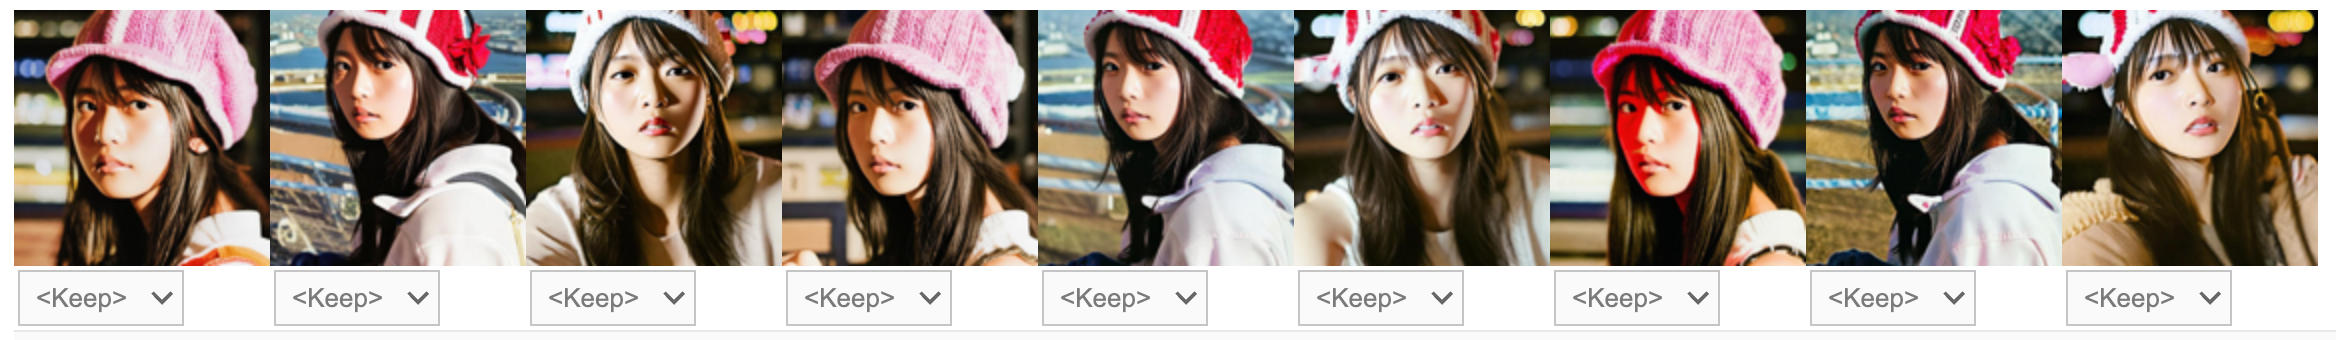

In [6]:
#| echo: false
import PIL; PIL.Image.open('results_2.png')

You can see from the above result that the model is now respecting the "wearing a hat" prompt.

# Appendix

## [Optional] xformers
xformers allows memory efficient attention to save GPU memory.
If not working, maybe run `pip install -U git+https://github.com/facebookresearch/xformers.git@main#egg=xformers` (takes a lot of time!)

In [ ]:
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import xformers
import torch

try:
  xformers.ops.memory_efficient_attention(
      torch.randn((1, 2, 40), device="cuda"),
      torch.randn((1, 2, 40), device="cuda"),
      torch.randn((1, 2, 40), device="cuda"),
  )
  print('xformers working')
except:
  print('xformers not working')
  raise